<a href="https://colab.research.google.com/github/schoucairm/chat-arena-nlp-eda/blob/main/Data200_GradProject_Checkpoint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Obtain and Clean the Data**

In [ ]:
# IMPORTS
from collections import defaultdict  # https://docs.python.org/3/library/collections.html Return a new dictionary-like object.
import json, math, gdown
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
# Provide the raw URL of the JSON file
url_conversations = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/chatbot-arena-conversations.jsonl.gz"

# Read the JSON file into a DataFrame
df = pd.read_json(url_conversations, lines=True)

# Display the first row of the data
df.head(1)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...


In [ ]:
# Examine data types of each column
df.dtypes

question_id       object
model_a           object
model_b           object
winner            object
judge             object
conversation_a    object
conversation_b    object
dtype: object

In [ ]:
# Examine null values in dataframe
df.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

In [ ]:
# Examine the winner types
df["winner"].value_counts()

model_a          9019
model_b          8873
tie (bothbad)    4641
tie              2789
Name: winner, dtype: int64

In [ ]:
print("FIG.1a")

fig = px.bar(df["winner"].value_counts(),
             title="Counts of Battle Outcomes", text_auto=True, height=400)
fig.update_layout(xaxis_title="Battle Outcome", yaxis_title="Count",
                  showlegend=False)
fig

FIG.1a


In [ ]:
print("FIG.1b")

def visualize_battle_count(battles, title):
    ptbl = pd.pivot_table(battles, index="model_a", columns="model_b", aggfunc="size",
                          fill_value=0)
    battle_counts = ptbl + ptbl.T
    ordering = battle_counts.sum().sort_values(ascending=False).index
    fig = px.imshow(battle_counts.loc[ordering, ordering],
                    title=title, text_auto=True, width=600)
    fig.update_layout(xaxis_title="Model B",
                      yaxis_title="Model A",
                      xaxis_side="top", height=600, width=600,
                      title_y=0.07, title_x=0.5)
    fig.update_traces(hovertemplate=
                      "Model A: %{y}<br>Model B: %{x}<br>Count: %{z}<extra></extra>")
    return fig

fig = visualize_battle_count(df, title="Battle Count of Each Combination of Models")
fig

FIG.1b


In [ ]:
# Remove rows with tie (bothbad) and tie as winners
df = df.loc[~df["winner"].isin(["tie (bothbad)", "tie"])]

# Verify new winner types
df["winner"].value_counts()

model_a    9019
model_b    8873
Name: winner, dtype: int64

In [ ]:
# Create a prompt column
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt"].head(1)

0    What is the difference between OpenCL and CUDA?
Name: prompt, dtype: object

In [ ]:
# Summary statistics of the length of prompts
df["prompt_length"] = df["prompt"].str.len()
df["prompt_length"].describe()

count   17892.00
mean      197.51
std       374.50
min        16.00
25%        42.00
50%        70.00
75%       150.00
max      2560.00
Name: prompt_length, dtype: float64

FIG.2


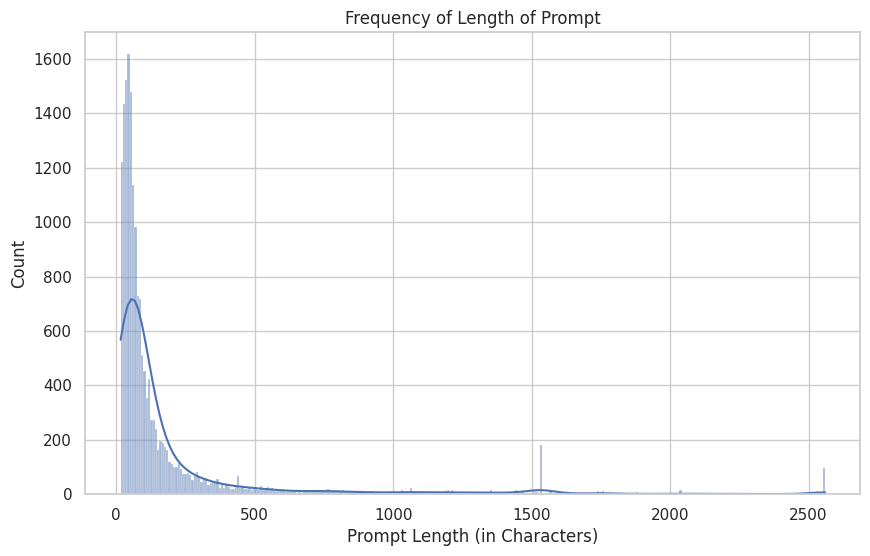

In [ ]:
print("FIG.2")

# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
plt.title("Frequency of Length of Prompt")
plt.xlabel("Prompt Length (in Characters)")
plt.ylabel("Count")
sns.histplot(df["prompt_length"], kde=True);

In [ ]:
# Provide the raw URL of the JSON file
url_scores = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/chatbot-arena-gpt3-scores.jsonl.gz"

# Read the JSON file into a DataFrame
topic_and_hardness = pd.read_json(url_scores, lines=True)

# Display the first row of the data
topic_and_hardness.head(1)

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9,Software Comparison,This prompt assesses the AI's factual accuracy...,8,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9


In [ ]:
# Examine data types of each column
topic_and_hardness.dtypes

question_id                         object
prompt                              object
openai_scores_raw_choices_nested    object
topic_modeling_1                    object
score_reason_1                      object
score_value_1                       object
topic_modeling_2                    object
score_reason_2                      object
score_value_2                       object
topic_modeling_3                    object
score_reason_3                      object
score_value_3                       object
dtype: object

In [ ]:
# Examine null values in dataframe
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    27
score_reason_1                      27
score_value_1                       27
topic_modeling_2                    27
score_reason_2                      27
score_value_2                       27
topic_modeling_3                    27
score_reason_3                      27
score_value_3                       27
dtype: int64

In [ ]:
# Examine if there are any/how many null values are in the score values
display(topic_and_hardness["score_value_1"].isna().sum())
display(topic_and_hardness["score_value_2"].isna().sum())
display(topic_and_hardness["score_value_3"].isna().sum())

27

27

27

In [ ]:
# Remove null values from scores values
topic_and_hardness = topic_and_hardness.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])
print(topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].isna().sum())

score_value_1    0
score_value_2    0
score_value_3    0
dtype: int64


In [ ]:
# Check what the non-integer values are in score values
topic_and_hardness["score_value_1"][topic_and_hardness["score_value_1"].apply(
    lambda x: isinstance(x, list))].head()

12     [[8]]
54     [[7]]
92     [[7]]
150    [[8]]
187    [[7]]
Name: score_value_1, dtype: object

In [ ]:
# Change all score values to be numeric
topic_and_hardness.loc[:,'score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness.loc[:,'score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness.loc[:,'score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

# Drop any resulting null values
topic_and_hardness= topic_and_hardness.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])

# Change all score values to be integers
topic_and_hardness['score_value_1'] = topic_and_hardness['score_value_1'].astype(np.int64)
topic_and_hardness['score_value_2'] = topic_and_hardness['score_value_2'].astype(np.int64)
topic_and_hardness['score_value_3'] = topic_and_hardness['score_value_3'].astype(np.int64)

# Verify all score values are integers
topic_and_hardness.dtypes

<ipython-input-18-78d9f165e00b>:2: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-18-78d9f165e00b>:3: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-18-78d9f165e00b>:4: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

<ipython-input-18-78d9f165e00b>:10: SettingWithCopyWarning:


A value is try

question_id                         object
prompt                              object
openai_scores_raw_choices_nested    object
topic_modeling_1                    object
score_reason_1                      object
score_value_1                        int64
topic_modeling_2                    object
score_reason_2                      object
score_value_2                        int64
topic_modeling_3                    object
score_reason_3                      object
score_value_3                        int64
dtype: object

# **2. EDA**
For the EDA tasks, tell us more about the data. What do you see in the data? Come up with questions and answers about them. For example, what is the win rate of GPT4? What are the most common topics? Do different judges have different preferences? What are the most common topics? What are the most common reasons for a question being hard?

(REF: https://colab.research.google.com/drive/1KdwokPjirkTmpO_P1WByFNFiqxWQquwH)

REQUIREMENTS
1. Ranking of the model based on their win rate or ELO ratings.
2. Distribution of the prompt and response length.
3. Hardness score distribution and its correlation with the models (e.g. GPT4 wins on hardest prompts).
4. (Open-ended) Visualize the “variance” in model performance (see LMSys Leaderboard for an example).
5. (Open-ended) Explore the prompt topics in the dataset (topic modeling).

## **2a. Ranking of the model based on their win rate or ELO ratings.**



In [ ]:
# Calculate Win Rates:
# Calculate the win rate for each model by counting the number of wins and losses.
# You can also calculate other metrics such as the number of matches played.

# Calculate ELO Ratings:
# If you want to calculate ELO ratings, you'll need to implement the ELO rating system.
# This involves assigning initial ratings to each model, updating the ratings after each match based on the outcome,
# and applying a K-factor to control the sensitivity of rating updates.

# Ranking: Once you have win rates or ELO ratings calculated,
# you can rank the models based on these metrics.

# Create a new column in df with the winner's name
df.loc[df["winner"] == "model_a", "winner_name"] = df["model_a"]
df.loc[df["winner"] == "model_b", "winner_name"] = df["model_b"]
df["winner_name"].value_counts()

# Calculate win rate of each model
win_rates = df["winner_name"].value_counts() / (df["model_a"].value_counts() + df["model_b"].value_counts())
win_rates.sort_values(ascending=False)

gpt-4                     0.85
claude-v1                 0.80
claude-instant-v1         0.76
gpt-3.5-turbo             0.71
vicuna-13b                0.62
guanaco-33b               0.60
palm-2                    0.59
wizardlm-13b              0.54
koala-13b                 0.51
vicuna-7b                 0.45
mpt-7b-chat               0.35
alpaca-13b                0.35
oasst-pythia-12b          0.35
gpt4all-13b-snoozy        0.34
RWKV-4-Raven-14B          0.34
chatglm-6b                0.30
fastchat-t5-3b            0.30
stablelm-tuned-alpha-7b   0.26
dolly-v2-12b              0.23
llama-13b                 0.20
dtype: float64

In [ ]:
print("FIG. 3")

winner_name_counts = df['winner_name'].value_counts()

fig5 = px.bar(winner_name_counts.sort_values(ascending=False),
             title="Frequency of Winners",
             text_auto=".2f")
fig5.update_layout(yaxis_title="Count", xaxis_title="Model Name",
                  showlegend=False)

FIG. 3


In [ ]:
print("FIG.4")

fig = px.bar(win_rates.sort_values(ascending=False),
             title="Average Win Rate Against All Other Models (Assuming Uniform Sampling and No Ties)",
             text_auto=".2f")
fig.update_layout(yaxis_title="Average Win Rate", xaxis_title="Model Name",
                  showlegend=False)
fig

FIG.4


## **2b. Distribution of the prompt and response length.**

FIG.5a


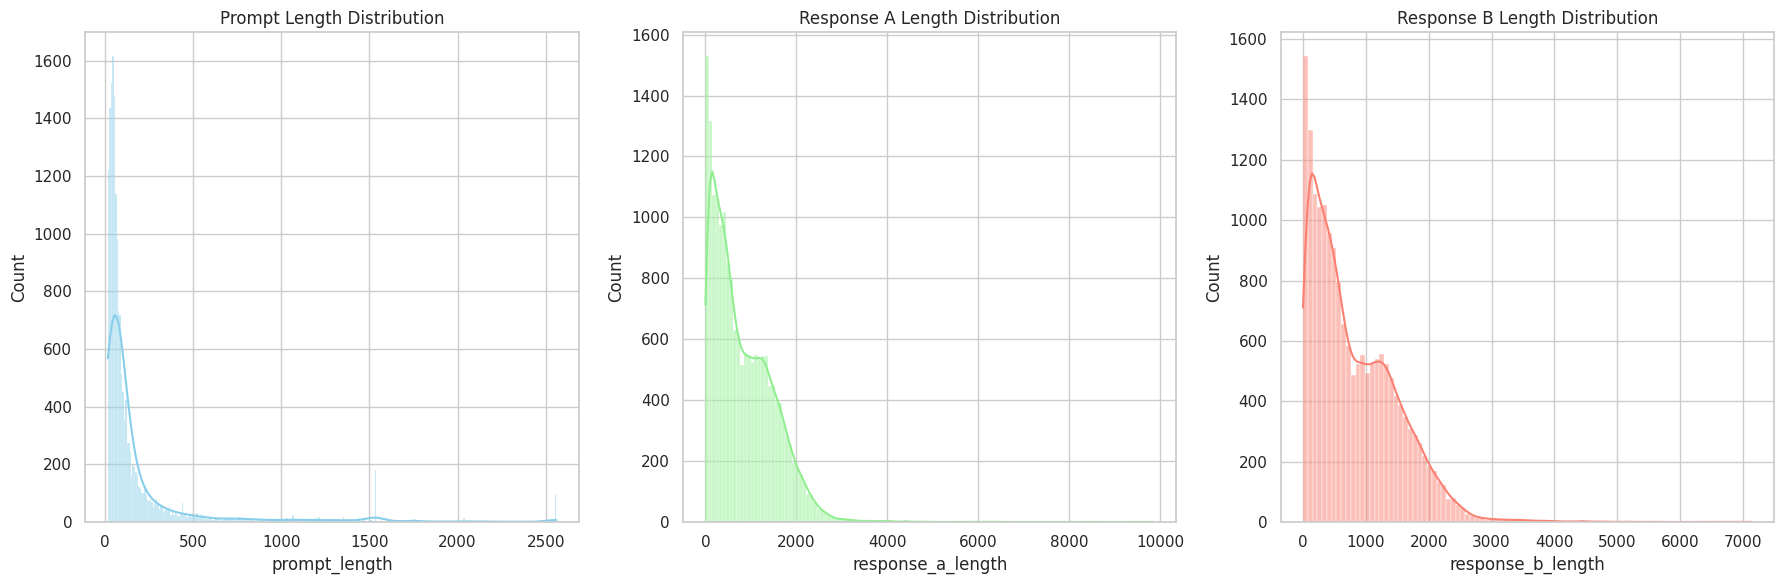

In [ ]:
print("FIG.5a")

# Create new columns in df with the length of both responses
df["response_a_length"] = df["conversation_a"].str[1].str["content"].str.len()
df["response_b_length"] = df["conversation_b"].str[1].str["content"].str.len()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(data=df, x="prompt_length", color="skyblue", kde=True)
plt.title("Prompt Length Distribution")

plt.subplot(1, 3, 2)
sns.histplot(data=df, x="response_a_length", color="lightgreen", kde=True)
plt.title("Response A Length Distribution")

plt.subplot(1, 3, 3)
sns.histplot(data=df, x="response_b_length", color="salmon", kde=True)
plt.title("Response B Length Distribution")

plt.tight_layout()
plt.show();

FIG.5b


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log



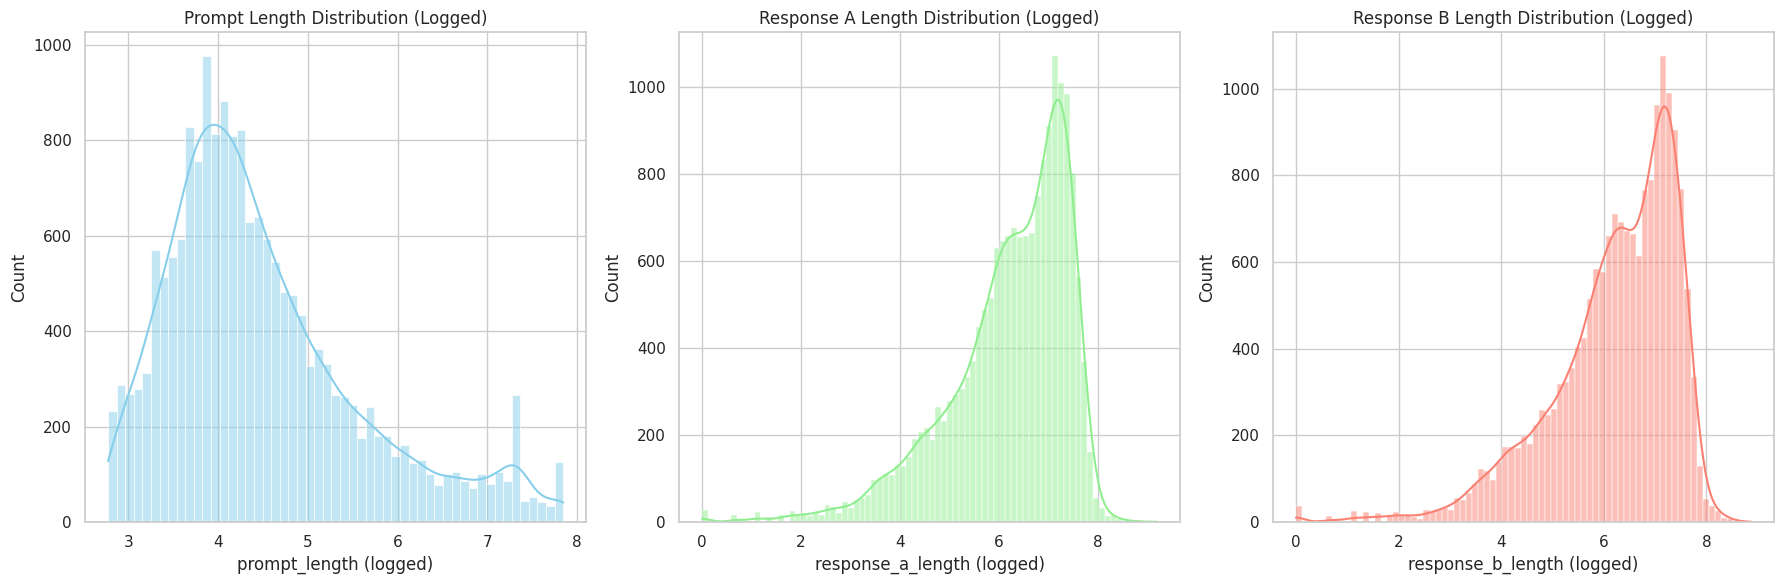

In [ ]:
print("FIG.5b")

# Log transformed lengths to view any patterns in distribution of values

# Create new columns in df with the length of both responses
df["prompt_length (logged)"] = np.log(df["prompt_length"])
df["response_a_length (logged)"] = np.log(df["conversation_a"].str[1].str["content"].str.len())
df["response_b_length (logged)"] = np.log(df["conversation_b"].str[1].str["content"].str.len())

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(data=df, x="prompt_length (logged)", color="skyblue", kde=True)
plt.title("Prompt Length Distribution (Logged)")

plt.subplot(1, 3, 2)
sns.histplot(data=df, x="response_a_length (logged)", color="lightgreen", kde=True)
plt.title("Response A Length Distribution (Logged)")

plt.subplot(1, 3, 3)
sns.histplot(data=df, x="response_b_length (logged)", color="salmon", kde=True)
plt.title("Response B Length Distribution (Logged)")

plt.tight_layout()
plt.show();

FIG. 5c


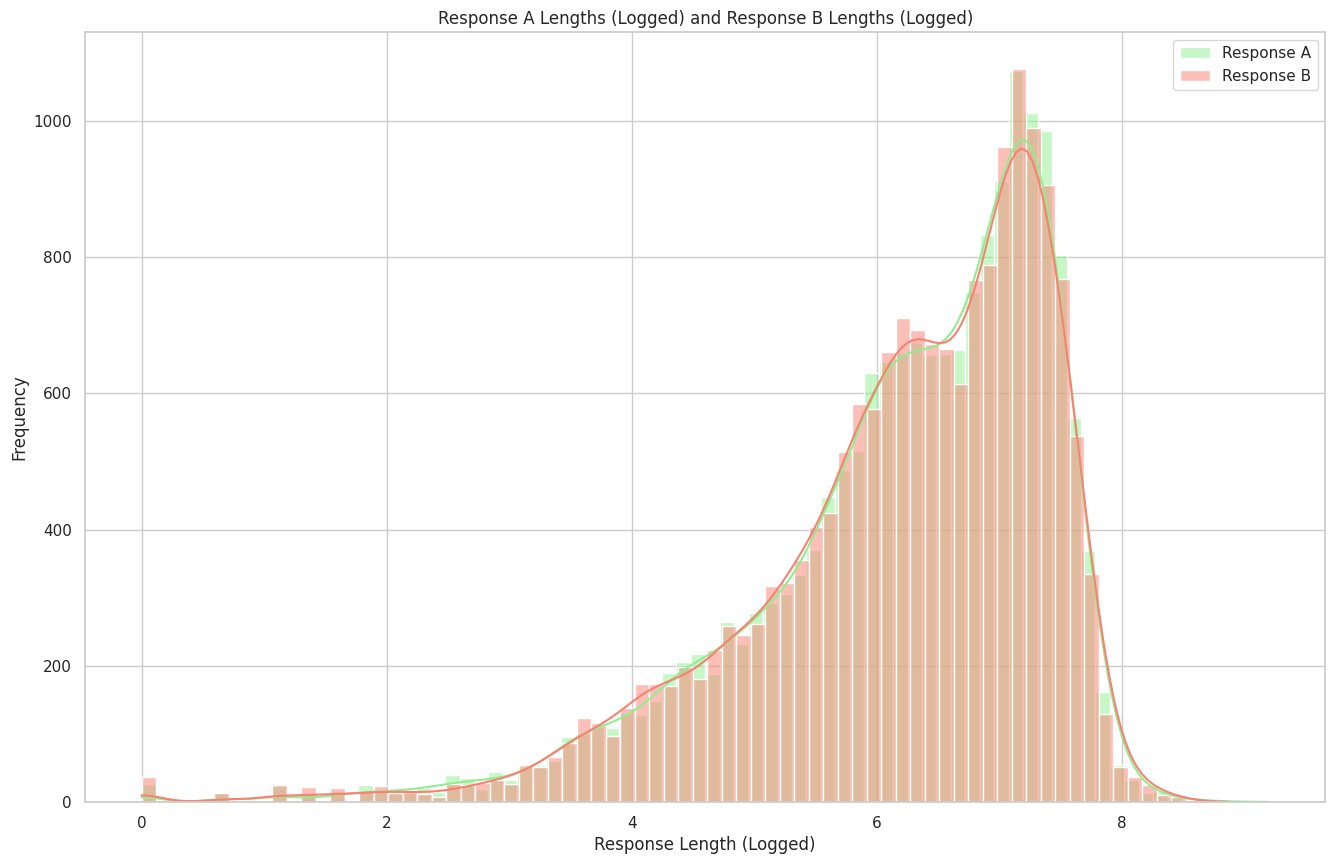

In [ ]:
print("FIG. 5c")

# Compare distribution of response lengths for A and B
plt.figure(figsize=(16, 10))

sns.histplot(data=df, x="response_a_length (logged)", color="lightgreen", kde=True, label="Response A")
sns.histplot(data=df, x="response_b_length (logged)", color="salmon", kde=True, label="Response B")

# Labels
plt.title("Response A Lengths (Logged) and Response B Lengths (Logged)")
plt.xlabel("Response Length (Logged)")
plt.ylabel("Frequency")
plt.legend()
plt.show();

FIG. 6


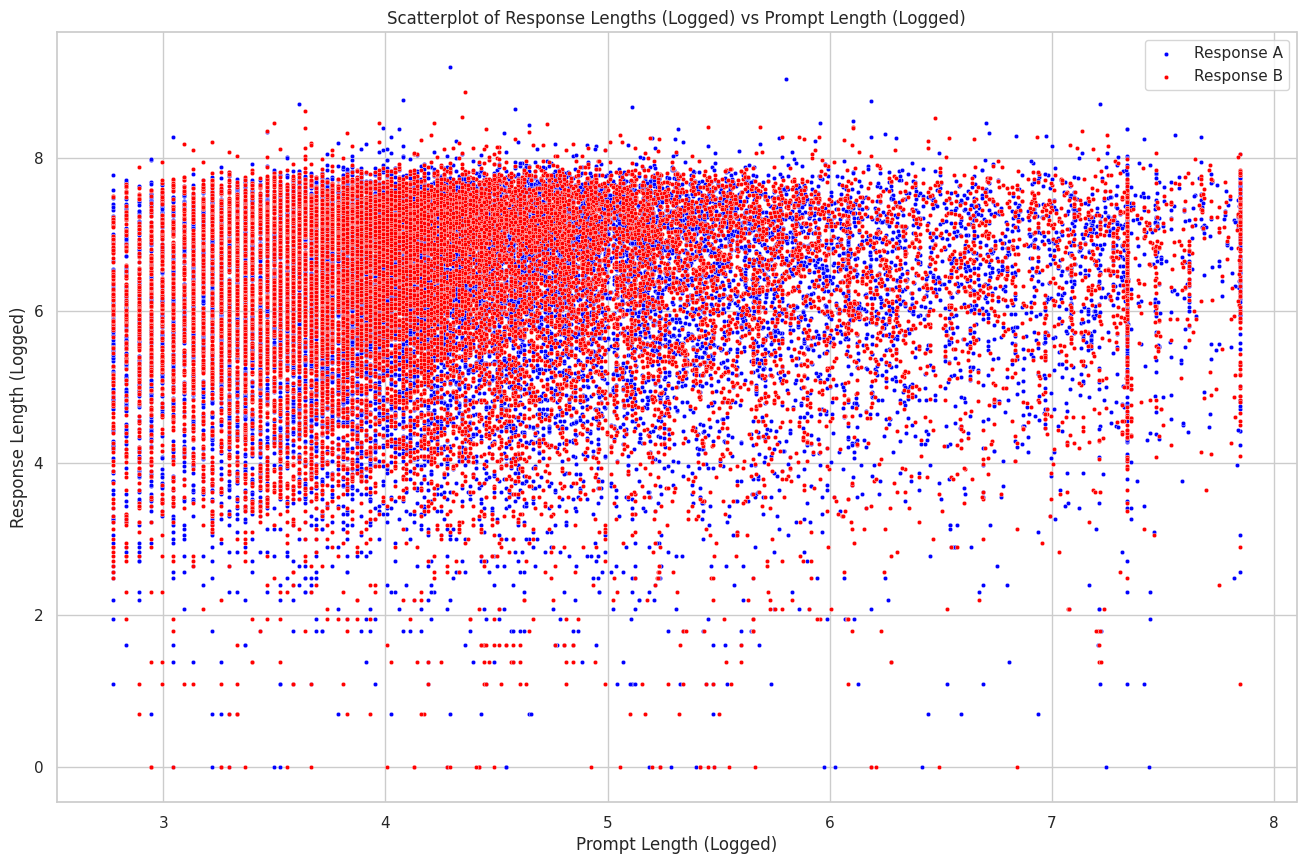

In [ ]:
print("FIG. 6")

# Look for any relationship between prompt length and response length
plt.figure(figsize=(16, 10))
# sns.scatterplot(data=df, x="prompt_length", y="response_a_length", color="blue", label="Response A", s=10)
# sns.scatterplot(data=df, x="prompt_length", y="response_b_length", color="red", label="Response B", s=10)

sns.scatterplot(data=df, x="prompt_length (logged)", y="response_a_length (logged)", color="blue", label="Response A", s=10)
sns.scatterplot(data=df, x="prompt_length (logged)", y="response_b_length (logged)", color="red", label="Response B", s=10)

# m, b = np.polyfit(x=df["prompt_length (logged)"], y=df["response_a_length (logged)"], 1)
# plt.plot(x, m*x + b, color='red')

# Labels
plt.title("Scatterplot of Response Lengths (Logged) vs Prompt Length (Logged)")
plt.xlabel("Prompt Length (Logged)")
plt.ylabel("Response Length (Logged)")
plt.legend()
plt.show()

## **2c. Hardness score distribution and its correlation with the models**:

In [ ]:
# View topic and hardness scores attributed to each battle
display(topic_and_hardness.head(3))
display(df.head(3))

,question_id,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3
0,58210e39b3fd4441a2bd4a518bb44c2d,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9,Software Comparison,This prompt assesses the AI's factual accuracy...,8,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9
1,2564acd09e3942fd97657d05282d4389,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","Reasoning, Emotion",This prompt requires the AI to understand huma...,9,"Emotions, Relationships",This prompt involves understanding complex hum...,8,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8
2,90bfd142157948aba01931726c888e7f,"Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",Camera comparison,This prompt does not require problem-solving s...,2,Comparative Analysis,This prompt assesses the AI's ability to analy...,6,Photography comparison,This prompt is subjective and does not provide...,2


,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,prompt_length,winner_name,response_a_length,response_b_length,prompt_length (logged),response_a_length (logged),response_b_length (logged)
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,47,koala-13b,892,1905,3.85,6.79,7.55
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?",32,oasst-pythia-12b,1114,1566,3.47,7.02,7.36
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,35,oasst-pythia-12b,1575,1624,3.56,7.36,7.39


In [ ]:
# Look at rationale structure of score choice
topic_and_hardness['openai_scores_raw_choices_nested'][0]

[{'finish_reason': 'stop',
  'index': 0,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Technical Comparison",\n    "score_reason": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI\'s factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",\n    "score_value": 9\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 1,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Software Comparison",\n    "score_reason": "This prompt assesses the AI\'s factual accuracy in distinguishing between two similar but distinct software frameworks.",\n    "score_value": 8\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 2,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeli

In [ ]:

hardness_df = df.merge(topic_and_hardness, on="question_id")[["question_id", "winner_name", "score_value_1", "score_value_2", "score_value_3"]]

# Add total (average) score for each battle
hardness_df["average_score"] = (hardness_df["score_value_1"] + hardness_df["score_value_2"] + hardness_df["score_value_3"])/ 3
hardness_df

,question_id,winner_name,score_value_1,score_value_2,score_value_3,average_score
0,58210e39b3fd4441a2bd4a518bb44c2d,koala-13b,9,8,9,8.67
1,90bfd142157948aba01931726c888e7f,oasst-pythia-12b,2,6,2,3.33
2,a7c5accc53e649a3bc6b2e41d962ebc4,oasst-pythia-12b,8,8,8,8.00
3,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,2,2,2,2.00
4,c0fc42c6f5f14f2aa5a89f71f8553730,vicuna-13b,7,2,2,3.67
...,...,...,...,...,...,...
17040,cf48ede921a047d187aa029a7acd98dd,fastchat-t5-3b,7,2,7,5.33
17041,471beeffa2d347a6bd499db66a74254c,palm-2,7,3,7,5.67
17042,fb4d58ef8649472783d364a9c1c8239e,palm-2,7,7,8,7.33
17043,86063a921be548989c55b85497ab009a,claude-instant-v1,8,9,7,8.00


FIG. 7a


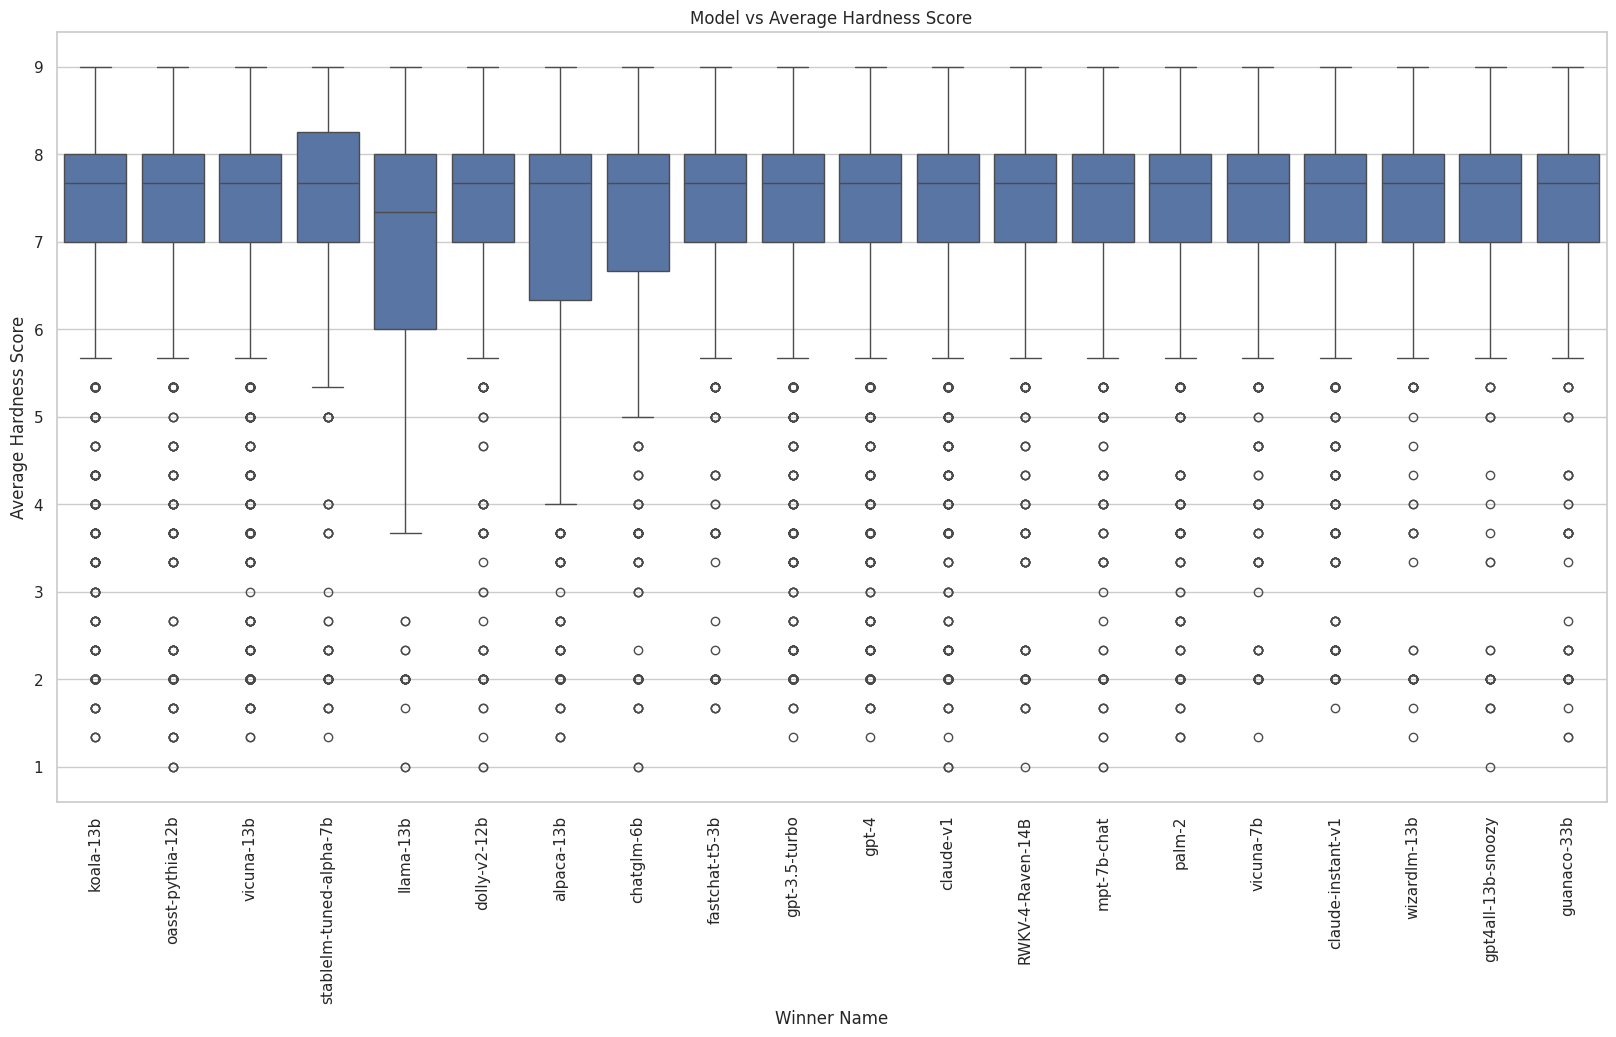

In [ ]:
print("FIG. 7a")

plt.figure(figsize=(20, 10))

sns.boxplot(data=hardness_df, x="winner_name", y="average_score")
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.xlabel("Winner Name")
plt.ylabel("Average Hardness Score")
plt.title("Model vs Average Hardness Score");

FIG. 7b


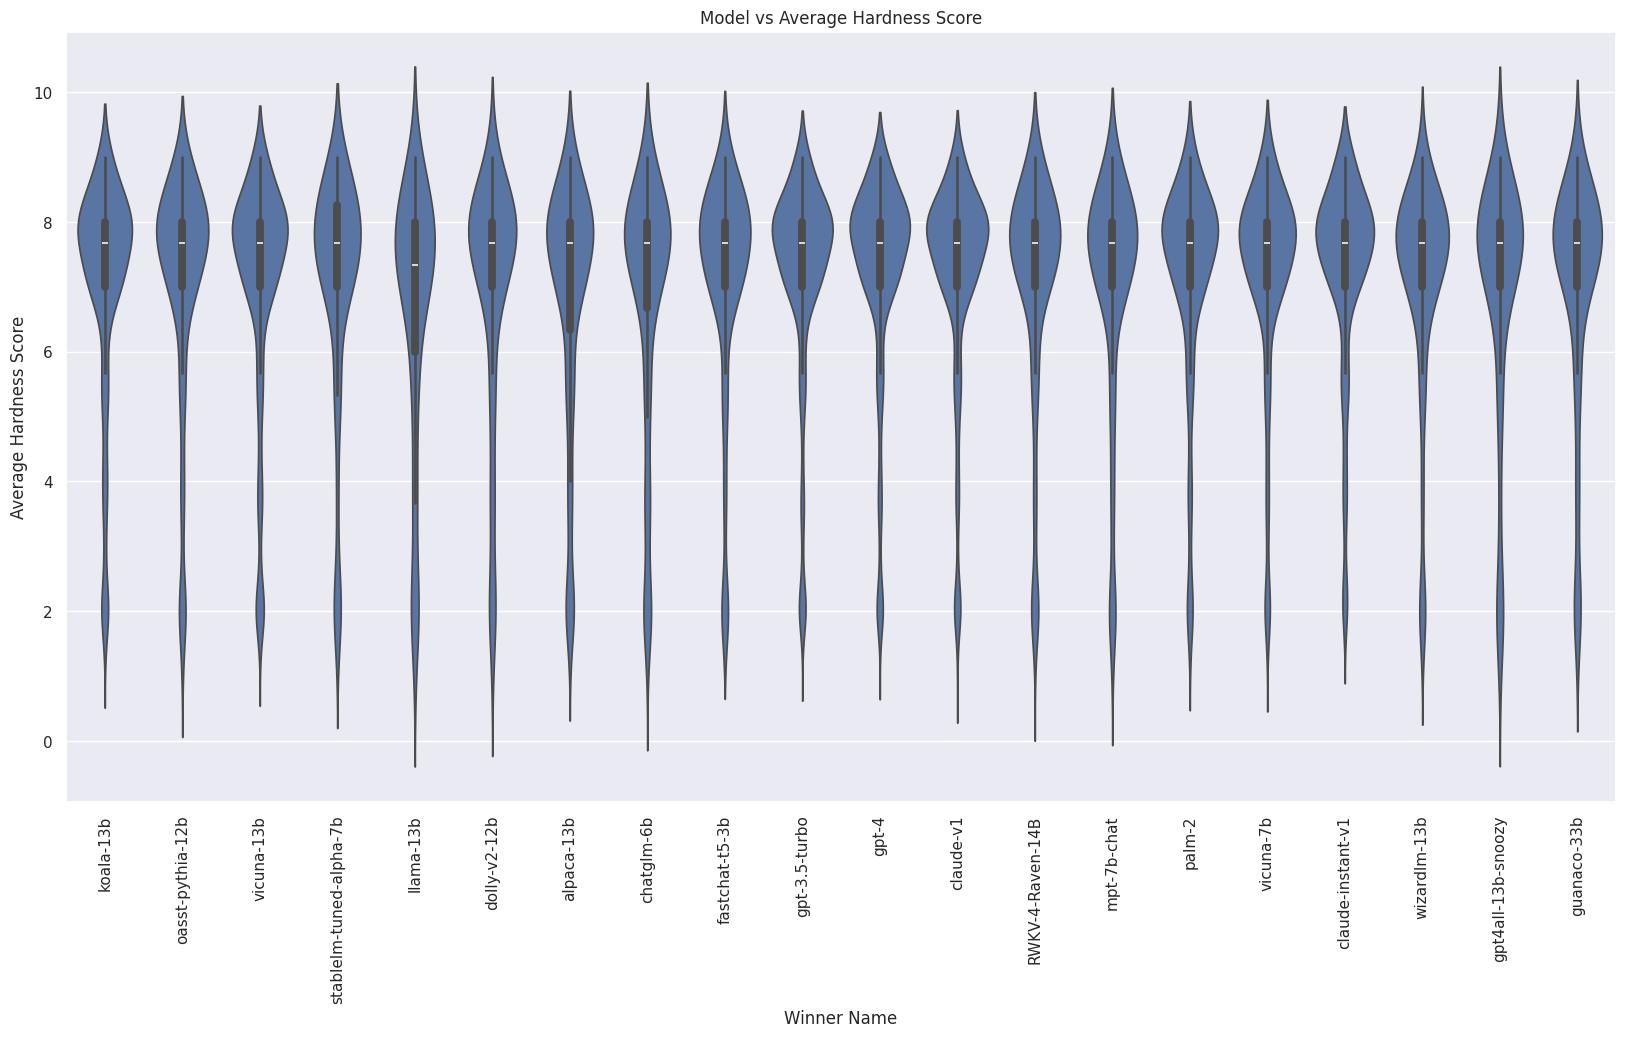

In [ ]:
print("FIG. 7b")

plt.figure(figsize=(20, 10))

sns.violinplot(data=hardness_df, x="winner_name", y="average_score")
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.xlabel("Winner Name")
plt.ylabel("Average Hardness Score")
plt.title("Model vs Average Hardness Score");

In [ ]:
average_hardness_per_model = hardness_df.groupby("winner_name")["average_score"].mean().sort_values(ascending=False)
average_hardness_per_model

winner_name
claude-instant-v1         7.26
gpt-4                     7.25
gpt-3.5-turbo             7.22
vicuna-7b                 7.21
claude-v1                 7.20
palm-2                    7.14
fastchat-t5-3b            7.12
wizardlm-13b              7.10
oasst-pythia-12b          7.07
vicuna-13b                7.07
koala-13b                 7.06
RWKV-4-Raven-14B          7.05
stablelm-tuned-alpha-7b   7.05
mpt-7b-chat               7.00
guanaco-33b               6.97
gpt4all-13b-snoozy        6.93
dolly-v2-12b              6.91
alpaca-13b                6.84
chatglm-6b                6.81
llama-13b                 6.67
Name: average_score, dtype: float64

In [ ]:
print("FIG. 8")

fig = px.bar(average_hardness_per_model,
             title="Average Hardness Score per Model in Winning Rounds",
             text_auto=".2f")
fig.update_layout(yaxis_title="Average Hardness Score", xaxis_title="Model Name",
                  showlegend=False)
fig

FIG. 8


## **2d (Open-ended) Visualize the “variance” in model performance (see LMSys Leaderboard for an example)**:

In [ ]:

names_list = winner_name_counts.index.tolist()
variance_list = []

for name in names_list:
  n = len(hardness_df[hardness_df['winner_name'] == name])
  score = hardness_df[hardness_df['winner_name'] == name]['average_score']
  mean_score = np.mean(hardness_df[hardness_df['winner_name'] == name]['average_score'])


  variance_list.append(sum((score - mean_score)**2) / (n - 1))

print(variance_list)

[2.5270225283707584, 3.1705757226107063, 2.5570000790954026, 2.569561244198593, 3.0559744398449413, 2.436523816028335, 2.786403034364969, 3.2951551845718803, 3.732999775180909, 3.2292640052885977, 2.507112647966309, 3.9353527571255613, 3.3620503296003825, 2.995301363655096, 3.4196283924244772, 3.742286480150556, 3.438936608892673, 2.829891987132357, 4.153282698981617, 3.7388622773238147]


In [ ]:
print("FIG. 9a")

average_hardness_per_model_df = hardness_df.groupby("winner_name")[["average_score"]].mean().sort_values(by = "average_score", ascending=False).reset_index()


variance_leaderboard = (pd.DataFrame({'Name': names_list, 'Variance': variance_list}) \
                        .sort_values('Variance', ascending=False) \
                        .merge(average_hardness_per_model_df, left_on='Name', right_on='winner_name') \
                        .drop(columns='winner_name')
                        .rename(columns= {"average_score": "Avg_Hardness_Score"}))

display(variance_leaderboard)

FIG. 9a


,Name,Variance,Avg_Hardness_Score
0,llama-13b,4.15,6.67
1,chatglm-6b,3.94,6.81
2,dolly-v2-12b,3.74,6.91
3,gpt4all-13b-snoozy,3.74,6.93
4,alpaca-13b,3.73,6.84
5,guanaco-33b,3.44,6.97
6,stablelm-tuned-alpha-7b,3.42,7.05
7,mpt-7b-chat,3.36,7.00
8,oasst-pythia-12b,3.30,7.07
9,RWKV-4-Raven-14B,3.23,7.05


FIG. 9b


<Figure size 2000x1200 with 0 Axes>

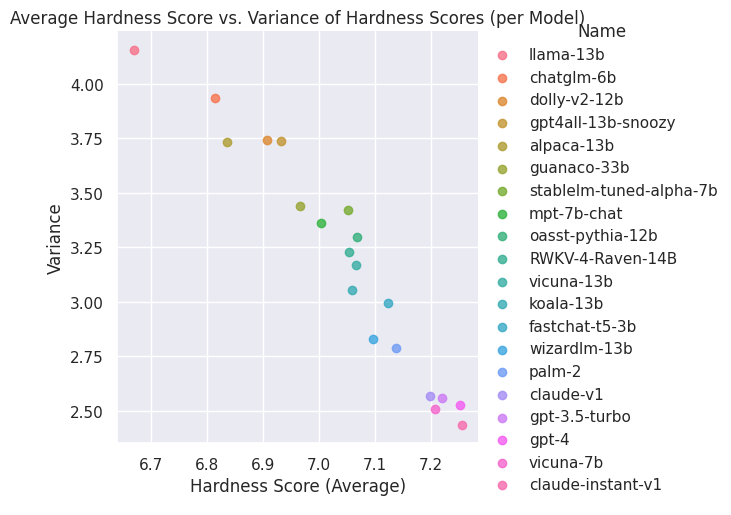

In [ ]:
print("FIG. 9b")

plt.figure(figsize=(20, 12))
sns.lmplot(data=variance_leaderboard, x='Avg_Hardness_Score', y='Variance', hue='Name', fit_reg=False)
plt.title("Average Hardness Score vs. Variance of Hardness Scores (per Model)")
plt.xlabel("Hardness Score (Average)")
plt.ylabel("Variance")
#plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.show();

## **2e.(Open-ended) Explore the prompt topics in the dataset (topic modeling).**

In [ ]:
topic_and_hardness[["topic_modeling_1", "topic_modeling_2", "topic_modeling_3"]]

,topic_modeling_1,topic_modeling_2,topic_modeling_3
0,Technical Comparison,Software Comparison,"Comparison, Technology"
1,"Reasoning, Emotion","Emotions, Relationships","Reasoning, Emotional"
2,Camera comparison,Comparative Analysis,Photography comparison
3,Chatbot Arena,Chatbot Arena,Chatbot Arena
4,Time Query,Date Inquiry,Time-based Inquiry
...,...,...,...
25317,"Mathematics, Measurement",Mathematical Calculation,"Mathematics, Problem-solving"
25318,Information Retrieval,Factual Recall,Factual knowledge
25319,"Training, Hyperparameters",Machine Learning - Hyperparameter Optimization,Machine Learning
25320,Language Modeling,Language Model Evaluation,Language modeling


In [ ]:
# Concatenate the three topic models columns
combined_topic_modeling = pd.concat([topic_and_hardness['topic_modeling_1'], topic_and_hardness['topic_modeling_2'], topic_and_hardness['topic_modeling_3']])
combined_topic_modeling.value_counts()

Creative Writing                   1655
Factual Accuracy                   1493
Problem-solving, Creativity        1108
Factual Knowledge                   898
Problem Solving                     828
                                   ... 
Entertainment, Idol                   1
Book Selection                        1
Embedded Systems, Configuration       1
Finance, Theory                       1
Relationship Management               1
Length: 20931, dtype: int64

In [ ]:
# Same as above but turns everything into lowercase

# Concatenate the three topic models columns
topic_and_hardness["topic_modeling_1_lower"] = topic_and_hardness["topic_modeling_1"].str.lower().str.replace('-', ' ')
topic_and_hardness["topic_modeling_2_lower"] = topic_and_hardness["topic_modeling_2"].str.lower().str.replace('-', ' ')
topic_and_hardness["topic_modeling_3_lower"] = topic_and_hardness["topic_modeling_3"].str.lower().str.replace('-', ' ')
# topic_and_hardness.head(1)

combined_topic_modeling_lower = pd.concat([topic_and_hardness['topic_modeling_1_lower'], topic_and_hardness['topic_modeling_2_lower'], topic_and_hardness['topic_modeling_3_lower']])
combined_topic_modeling_lower.value_counts()

creative writing               1775
problem solving, creativity    1660
factual accuracy               1582
problem solving                1329
factual knowledge               941
                               ... 
sport definition                  1
philosophy, coherence             1
physics, information              1
ai, problem solving               1
relationship management           1
Length: 18918, dtype: int64

In [ ]:
print("FIG. 10a")

# Look at the top 20 most frequent topics ()
top_20_topics = combined_topic_modeling.value_counts().head(20)
top_20_topics

# Visualize top 20 most frequent topics
fig = px.bar(top_20_topics.sort_values(ascending=False),
             title="Top 20 Most Frequent Topics",
             text_auto=".2f")
fig.update_layout(yaxis_title="Topic Count", xaxis_title="Topic",
                  showlegend=False)
fig.update_xaxes(tickangle=90)

fig

FIG. 10a


In [ ]:
# Same as above but calculates based on everything lowercase
print("FIG. 10b")

# Look at the top 20 most frequent topics ()
top_20_topics_lower = combined_topic_modeling_lower.value_counts().head(20)
top_20_topics_lower

# Visualize top 20 most frequent topics
fig = px.bar(top_20_topics_lower.sort_values(ascending=False),
             title="Top 20 Most Frequent Topic Tags",
             text_auto=".2f")
fig.update_layout(yaxis_title="Topic Count", xaxis_title="Topic Tag",
                  showlegend=False)
fig

FIG. 10b


In [ ]:
print("FIG. 10c")
# Same as above but calculates based on everything lowercase
# and separates by individual topic category,
# treating first item as primary topic

# Concatenate the three topic models columns
topic_and_hardness["topic_modeling_1_primary"] = topic_and_hardness["topic_modeling_1"].str.lower().str.replace('-', ' ').str.split(", ").str.get(0)
topic_and_hardness["topic_modeling_2_primary"] = topic_and_hardness['topic_modeling_2'].str.lower().str.replace('-', ' ').str.split(", ").str.get(0)
topic_and_hardness["topic_modeling_3_primary"] = topic_and_hardness['topic_modeling_3'].str.lower().str.replace('-', ' ').str.split(", ").str.get(0)
topic_and_hardness.head(3)

combined_topic_modeling_primary = pd.concat([topic_and_hardness['topic_modeling_1_primary'], topic_and_hardness['topic_modeling_2_primary'], topic_and_hardness['topic_modeling_3_primary']])
display(combined_topic_modeling_primary.value_counts())

# Look at the top 20 most frequent topics ()
top_20_topics_primary = combined_topic_modeling_primary.value_counts().head(20)
top_20_topics_primary

# Visualize top 20 most frequent topics
fig_10c = px.bar(top_20_topics_primary.sort_values(ascending=False),
             title="Top 20 Most Frequent Primary Topic Tags",
             text_auto=".2f")
fig_10c.update_layout(yaxis_title="Topic Count", xaxis_title="Primary Topic Tag",
                  showlegend=False)
fig_10c

FIG. 10c


problem solving            4921
creativity                 2960
creative writing           1781
factual accuracy           1689
mathematics                1622
                           ... 
emoji communication           1
mechanism understanding       1
creative assessment           1
sport definition              1
relationship management       1
Length: 13110, dtype: int64

In [ ]:
# Combine the mean and frequency count of each topic across all topic_modeling columns
topic_and_hardness['topic_modeling_1'] = topic_and_hardness['topic_modeling_1'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
topic_and_hardness['topic_modeling_1'] = topic_and_hardness['topic_modeling_1'].str.lower()

topic_1 = topic_and_hardness.groupby("topic_modeling_1")["score_value_1"].agg(['mean', 'count']).sort_values(by="mean", ascending=False).reset_index()

topic_and_hardness['topic_modeling_2'] = topic_and_hardness['topic_modeling_2'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
topic_and_hardness['topic_modeling_2'] = topic_and_hardness['topic_modeling_2'].str.lower()

topic_2 = topic_and_hardness.groupby("topic_modeling_2")["score_value_2"].agg(['mean', 'count']).sort_values(by="mean", ascending=False).reset_index()

topic_and_hardness['topic_modeling_3'] = topic_and_hardness['topic_modeling_3'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
topic_and_hardness['topic_modeling_3'] = topic_and_hardness['topic_modeling_3'].str.lower()

topic_3 = topic_and_hardness.groupby("topic_modeling_3")["score_value_3"].agg(['mean', 'count']).sort_values(by="mean", ascending=False).reset_index()

In [ ]:
# Merge dataframes to create one dataframe with all the topics, means, and frequency counts
topic_1_and_2 = topic_1.merge(topic_2, left_on = "topic_modeling_1", right_on = "topic_modeling_2")
topic_1_and_2

all_topics = topic_1_and_2.merge(topic_3, left_on = "topic_modeling_1", right_on = "topic_modeling_3")
all_topics["count"] = all_topics["count_x"] + all_topics["count_y"] + all_topics["count"]
all_topics["mean"] = (all_topics["mean_x"] + all_topics["mean_y"] + all_topics["mean"]) / 3
all_topics = all_topics.drop(["mean_x", "count_x", "mean_y", "count_y", "topic_modeling_2", "topic_modeling_3"], axis=1)
all_topics = all_topics.rename(columns = {"topic_modeling_1": "topic_modeling", "mean": "average hardness score", "count": "frequency"})

all_topics

,topic_modeling,average hardness score,frequency
0,programming equivalency,8.33,3
1,training plan,8.50,6
2,training program,8.17,5
3,medical report,8.83,4
4,medical translation,9.00,3
...,...,...,...
3849,"cybersecurity, hacking",1.11,6
3850,dark humor,2.17,4
3851,casual greeting,1.00,4
3852,casual conversation,1.50,10


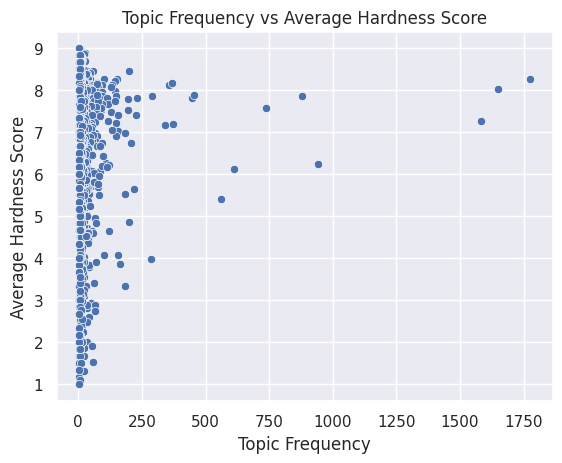

In [ ]:
# Is there a relationship between average hardness score and frequency of topic?
sns.scatterplot(data = all_topics, x = "frequency", y = "average hardness score")
plt.xlabel("Topic Frequency")
plt.ylabel("Average Hardness Score")
plt.title("Topic Frequency vs Average Hardness Score");

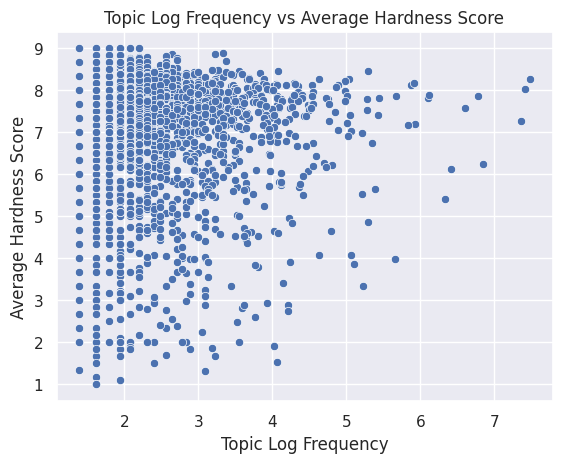

In [ ]:
# Apply a log transformation for better visualization
all_topics['log_frequency'] = np.log1p(all_topics['frequency'])

sns.scatterplot(data = all_topics, x = "log_frequency", y = "average hardness score")
plt.xlabel("Topic Log Frequency")
plt.ylabel("Average Hardness Score")
plt.title("Topic Log Frequency vs Average Hardness Score");

FIG. 12


<Figure size 2000x1200 with 0 Axes>

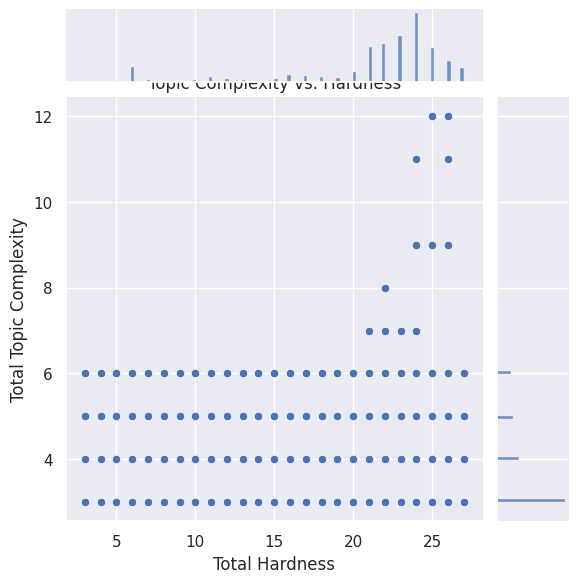

In [ ]:
print("FIG. 12")

# Is there a relationship between number of topics ("topic modeling complexity") and total hardness score?
# ie: does having more than one topic listed affect the hardness score?

plt.figure(figsize=(20,12))
# Concatenate the three topic models columns
topic_and_hardness["topic_modeling_1_complexity"] = topic_and_hardness["topic_modeling_1"].astype(str).str.lower().str.split(", ").apply(lambda x: len(x))
topic_and_hardness["topic_modeling_2_complexity"] = topic_and_hardness["topic_modeling_2"].astype(str).str.lower().str.split(", ").apply(lambda x: len(x))
topic_and_hardness["topic_modeling_3_complexity"] = topic_and_hardness["topic_modeling_3"].astype(str).str.lower().str.split(", ").apply(lambda x: len(x))
topic_and_hardness["total_topic_complexity"] = topic_and_hardness["topic_modeling_1_complexity"] + topic_and_hardness["topic_modeling_2_complexity"] + topic_and_hardness["topic_modeling_3_complexity"]
topic_and_hardness["total_hardness"] = topic_and_hardness["score_value_1"] + topic_and_hardness["score_value_2"] + topic_and_hardness["score_value_3"]
topic_and_hardness.head()

sns.jointplot(data = topic_and_hardness, x = "total_hardness", y = "total_topic_complexity")

plt.title("Topic Complexity vs. Hardness")
plt.xlabel("Total Hardness")
plt.ylabel("Total Topic Complexity")
plt.show()

In [ ]:
topic_and_hardness["total_topic_complexity"].value_counts()

3     13728
4      4375
5      3130
6      2855
7         7
9         5
12        3
11        2
8         1
Name: total_topic_complexity, dtype: int64

FIG. 13


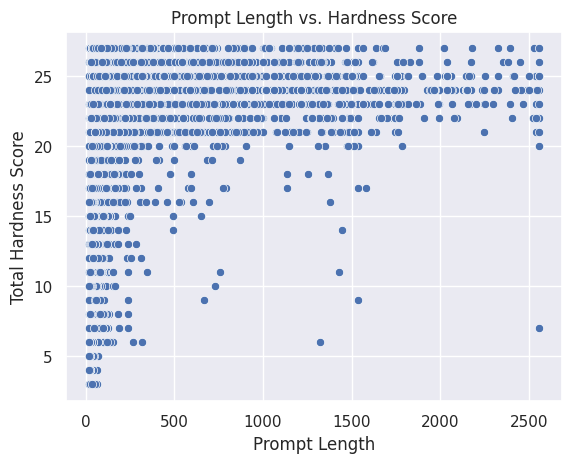

In [ ]:
print("FIG. 13")

# Is there a relationship between length of prompt and hardness?

sns.scatterplot(x= df["prompt_length"], y = topic_and_hardness["total_hardness"])
plt.title("Prompt Length vs. Hardness Score")
plt.xlabel("Prompt Length")
plt.ylabel("Total Hardness Score")
plt.show()